In [98]:
import pandas as pd
import numpy as np
import os
import sys
from pprint import pprint
import configparser
from collections import Counter
from sklearn.metrics import classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt

sys.path.append(os.path.abspath('../../Module'))
import preprocessing
import evaluation
import visualize

config = configparser.ConfigParser()
config.read('../../config.ini')

vg_json = config['PATHS']['vg-json']
vg_json_export = config['PATHS']['json-export']
image_dir = config['PATHS']['vg-images']
input_dir = vg_json_export+'prediction_arrays/'

colors = preprocessing.basic_colors()
classifier_list = 'bottomup topdown topdown_multitask combined'.split()


input_test = vg_json_export + 'test_predictions/'

set_type = 'test'

# Diagramme etc als Graustufen anzeigen. Verwendung: greyscale(labels), ergibt Liste von Farbwerten
greyscale = lambda x: plt.cm.gray(np.linspace(0.2,0.8,len(x)))

### Prediction-Arrays importieren

In [99]:
# Gezippte Numpy-Archive importieren
bottomup_arrays = np.load(input_dir+'results_perceptron_bgr.npz')
topdown_arrays = np.load(input_dir+'results_vgg16_simple.npz')
topdown_multitask_arrays = np.load(input_dir+'results_vgg16_jointlearning.npz')

# Prediction-Arrays aus importierten Numpy-Dateien
bottomup_predict = bottomup_arrays['predict_'+set_type+'_y']
topdown_predict = topdown_arrays['predict_'+set_type+'_y']
topdown_multitask_predict = topdown_multitask_arrays['predict_'+set_type+'_y']

# IDs zu Prediction-Arrays hinzufügen
ids = bottomup_arrays[set_type+'_y'][:,0:1]
bottomup_predict = np.append(ids, bottomup_predict, axis=1)
ids = topdown_arrays[set_type+'_y'][:,0:1]
topdown_predict = np.append(ids, topdown_predict, axis=1)
ids = topdown_multitask_arrays[set_type+'_y'][:,0:1]
topdown_multitask_predict = np.append(ids, topdown_multitask_predict, axis=1)

In [100]:
topdown_predict = pd.DataFrame(topdown_predict).sort_values(by=0).to_numpy()
topdown_multitask_predict = pd.DataFrame(topdown_multitask_predict).sort_values(by=0).to_numpy()
bottomup_predict = pd.DataFrame(bottomup_predict).loc[
    pd.DataFrame(bottomup_predict)[0].isin(topdown_predict[:,0].ravel())
    ].sort_values(by=0).to_numpy()
topdown_predict = pd.DataFrame(topdown_predict).loc[
    pd.DataFrame(topdown_predict)[0].isin(bottomup_predict[:,0].ravel())
    ].sort_values(by=0).to_numpy()
topdown_multitask_predict = pd.DataFrame(topdown_multitask_predict).loc[
    pd.DataFrame(topdown_multitask_predict)[0].isin(bottomup_predict[:,0].ravel())
    ].sort_values(by=0).to_numpy()
ids = topdown_predict[:,0].reshape(-1,1)
# Überprüfen, dass Shapes identisch sind
print ('Shapes identisch:',
       (bottomup_predict.shape == topdown_predict.shape), 
       bottomup_predict.shape)
# Überprüfen, dass IDs identisch sind
print ('IDs identisch:',(not False in (bottomup_predict[:,0:1] == topdown_predict[:,0:1])))

Shapes identisch: True (9053, 12)
IDs identisch: True


### Klassifikationsergebnisse kombinieren
Arithmetisches Mittel aus den Vorhersagen beider elementarer Klassifikatoren für jedes Objekt

In [106]:
combined_predict = (bottomup_predict[:,1:] + topdown_multitask_predict[:,1:]) / 2
combined_predict = np.append(ids, combined_predict, axis=1)

# Überprüfen, dass Shapes identisch sind
print ('Shapes identisch:',
       (bottomup_predict.shape == combined_predict.shape), 
       combined_predict.shape)
# Überprüfen, dass IDs identisch sind
print ('IDs identisch:',(not False in (bottomup_predict[:,0:1] == combined_predict[:,0:1])))

Shapes identisch: True (9053, 12)
IDs identisch: True


### DataFrames importieren + filtern, DataFrames für CDOs/CBOs/CNOs erstellen

In [107]:
all_obj = pd.read_csv(vg_json_export+"extracted_data/all_objects.csv", index_col=0)
test_obj = pd.read_csv(vg_json_export+"extracted_data/"+set_type+"_df.csv", index_col=0)

# Frequente Objekte + CDOs + CNOs:
frequent_objects, color_diagnostic_objects, color_biased_objects, color_neutral_objects = preprocessing.freq_cdo_cno(all_obj, num_cdos=100, num_cnos=100, min_num=100)
# DataFrame mit Objekten aus Prediction-Arrays
pred_obj = all_obj.loc[combined_predict[:,0]]
# DataFrames für CDOs, CBOs und CNOs
cd_obj = pred_obj.loc[pred_obj.object_name.isin(color_diagnostic_objects.keys())]
cb_obj = pred_obj.loc[pred_obj.object_name.isin(color_biased_objects)]
cn_obj = pred_obj.loc[pred_obj.object_name.isin(color_neutral_objects)]

print ('Anzahl Einträge in DataFrames:',dict(zip(('pred_obj','cd_obj','cb_obj','cn_obj'),(len(pred_obj),len(cd_obj),len(cb_obj),len(cn_obj)))))
# Überprüfen, ob prediction-Arrays gleich viele Einträge haben wie freq_obj
print ('Identische Indizes für Prediction-Arrays und DataFrame:', bottomup_predict[:,0:1].ravel().astype(int).tolist() == pred_obj.index.tolist())

/home/simeon/Masterarbeit/VirtualEnvs/ma-venv/lib/python3.5/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Anzahl Einträge in DataFrames: {'pred_obj': 9053, 'cb_obj': 883, 'cd_obj': 1141, 'cn_obj': 1755}
Identische Indizes für Prediction-Arrays und DataFrame: True


## Predictions und Test-DF zusammenführen
Resultat: Ein DF pro Bedingung (alle Objekte, CDO, CBO, CNO)

In [108]:
# DataFrames aus Predictions (np-Arrays) erstellen
bottomup_predict_df =  pd.DataFrame(data=bottomup_predict[0:,1:],index=bottomup_predict[0:,0],columns=colors).sort_index().astype('float')
topdown_predict_df =  pd.DataFrame(data=topdown_predict[0:,1:],index=topdown_predict[0:,0],columns=colors).sort_index().astype('float')
topdown_multitask_predict_df =  pd.DataFrame(data=topdown_multitask_predict[0:,1:],index=topdown_multitask_predict[0:,0],columns=colors).sort_index().astype('float')
combined_predict_df =  pd.DataFrame(data=combined_predict[0:,1:],index=combined_predict[0:,0],columns=colors).sort_index().astype('float')

# Farbwort mit höchstem Wert (-> prognostiziertes Farbwort) (ergibt pd.Series)
pred_label_bottomup = bottomup_predict_df.idxmax(axis=1)
pred_label_topdown = topdown_predict_df.idxmax(axis=1)
pred_label_topdown_multitask = topdown_multitask_predict_df.idxmax(axis=1)
pred_label_combined = combined_predict_df.idxmax(axis=1)

# Predictions mit freq_obj kombinieren
predict_df = pred_obj.copy().sort_index()
predict_df = predict_df.merge(pred_label_bottomup.rename('bottomup_color'), left_index=True, right_index=True)
predict_df = predict_df.merge(pred_label_topdown.rename('topdown_color'), left_index=True, right_index=True)
predict_df = predict_df.merge(pred_label_topdown_multitask.rename('topdown_multitask_color'), left_index=True, right_index=True)
predict_df = predict_df.merge(pred_label_combined.rename('combined_color'), left_index=True, right_index=True)

# DFs für CDOs, CNOs und CBOs
predict_cdo = predict_df.loc[cd_obj.index.to_list()]
predict_cbo = predict_df.loc[cb_obj.index.to_list()]
predict_cno = predict_df.loc[cn_obj.index.to_list()]

predict_df.head()

bb_h  bb_w  bb_x  bb_y  color  image_id  object_id       object_name  \
9.0     128    54   382   369   gray         1    1058531             pants   
68.0    102   372   425   132  brown         5    1060364           shelves   
206.0   121    42     1   335  white        12    1024188  computer monitor   
400.0   197   279   314     0  green        23    1024613              tree   
433.0   291   178   508   151  green        26    1061195         pine tree   

      bottomup_color topdown_color topdown_multitask_color combined_color  
9.0             gray          gray                   black           gray  
68.0           white          blue                   brown          brown  
206.0           pink         black                   green           pink  
400.0          green          gray                   green          green  
433.0          brown         green                   brown          brown

### Entropie

## Ergebnisse überprüfen

In [109]:
accuracy_scores = {} 
print ('Accuracy\n---------')
for classifier in classifier_list:
    accuracy_scores.update(evaluation.print_scores(classifier, column=classifier+'_color', df=predict_df, df_cdo=predict_cdo, df_cno=predict_cno, df_cbo=predict_cbo, return_dict = True, metric='accuracy'))
# accuracy_scores als LaTeX-Tabelle:
print (pd.DataFrame(accuracy_scores).T[['Alle Objekte', 'Color-Diagnostic Objects', 'Color-Biased Objects', 'Color-Neutral Objects']].round(decimals=3).to_latex())

f1_scores = {} 
print ('f1\n---------')
for classifier in classifier_list:
    f1_scores.update(evaluation.print_scores(classifier, column=classifier+'_color', df=predict_df, df_cdo=predict_cdo, df_cno=predict_cno, df_cbo=predict_cbo, return_dict = True, metric='f1', average='macro'))
# f1_scores als LaTeX-Tabelle:
print (pd.DataFrame(f1_scores).T[['Alle Objekte', 'Color-Diagnostic Objects', 'Color-Biased Objects', 'Color-Neutral Objects']].round(decimals=3).to_latex())

Accuracy
---------
bottomup:
Metric: accuracy
{'Alle Objekte': 0.44250524687948745}
{'Color-Diagnostic Objects': 0.530236634531113}
{'Color-Biased Objects': 0.3827859569648924}
{'Color-Neutral Objects': 0.49173789173789173}


topdown:
Metric: accuracy
{'Alle Objekte': 0.4569755882028057}
{'Color-Diagnostic Objects': 0.5363716038562665}
{'Color-Biased Objects': 0.40656851642129105}
{'Color-Neutral Objects': 0.42792022792022794}


topdown_multitask:
Metric: accuracy
{'Alle Objekte': 0.36540373356898265}
{'Color-Diagnostic Objects': 0.558282208588957}
{'Color-Biased Objects': 0.3159682899207248}
{'Color-Neutral Objects': 0.3037037037037037}


combined:
Metric: accuracy
{'Alle Objekte': 0.490224235060201}
{'Color-Diagnostic Objects': 0.5985977212971078}
{'Color-Biased Objects': 0.434881087202718}
{'Color-Neutral Objects': 0.49914529914529915}


\begin{tabular}{lrrrr}
\toprule
{} &  Alle Objekte &  Color-Diagnostic Objects &  Color-Biased Objects &  Color-Neutral Objects \\
\midrule
bottomu

## Alle Objekte

In [10]:
for classifier in classifier_list:
    #print (classifier)
    #print (classification_report(predict_df['color'], predict_df[classifier+'_color'], digits=3))
    columns = [c for c in colors]
    columns.append('macro avg')
    report = pd.DataFrame(classification_report(predict_df['color'], predict_df[classifier+'_color'], output_dict=True))\
        .drop(['support'], axis=0).drop(['weighted avg'], axis=1)\
        [columns]\
        .T[['precision', 'recall', 'f1-score']].round(decimals=3)\
    # LaTeX
    #print (report.to_latex())

In [11]:
df = predict_df

bottomup_report = pd.DataFrame(classification_report(df['color'], df['bottomup'+'_color'], output_dict=True))[colors].T
bottomup_report['prec-rec-diff'] = bottomup_report.apply(lambda x: x.precision - x.recall, axis=1)
bottomup_report['prec-rec-diff_abs'] = bottomup_report.apply(lambda x: abs(x.precision - x.recall), axis=1)

topdown_report = pd.DataFrame(classification_report(df['color'], df['topdown'+'_color'], output_dict=True))[colors].T
topdown_report['prec-rec-diff'] = topdown_report.apply(lambda x: x.precision - x.recall, axis=1)
topdown_report['prec-rec-diff_abs'] = topdown_report.apply(lambda x: abs(x.precision - x.recall), axis=1)

combined_report = pd.DataFrame(classification_report(df['color'], df['combined'+'_color'], output_dict=True))[colors].T
combined_report['prec-rec-diff'] = combined_report.apply(lambda x: x.precision - x.recall, axis=1)
combined_report['prec-rec-diff_abs'] = combined_report.apply(lambda x: abs(x.precision - x.recall), axis=1)

In [12]:
metric = 'f1-score'

In [13]:
bottomup_report.sort_values(by=metric, ascending=False)
#bottomup_report.describe()

f1-score  precision    recall  support  prec-rec-diff  \
purple  0.531663   0.622150  0.464156    823.0       0.157994   
green   0.521984   0.486856  0.562576    823.0      -0.075720   
yellow  0.511870   0.488938  0.537060    823.0      -0.048121   
pink    0.509114   0.527344  0.492102    823.0       0.035242   
blue    0.500608   0.500608  0.500608    823.0       0.000000   
red     0.458371   0.367572  0.608748    823.0      -0.241177   
orange  0.442353   0.428734  0.456865    823.0      -0.028131   
black   0.409297   0.383634  0.438639    823.0      -0.055005   
brown   0.381412   0.378897  0.383961    823.0      -0.005064   
gray    0.311978   0.365416  0.272175    823.0       0.093241   
white   0.208754   0.339726  0.150668    823.0       0.189058   

        prec-rec-diff_abs  
purple           0.157994  
green            0.075720  
yellow           0.048121  
pink             0.035242  
blue             0.000000  
red              0.241177  
orange           0.028131  
black            0.055005  
brown            0.005064  
gray             0.093241  
white            0.189058

In [14]:
topdown_report.sort_values(by=metric, ascending=False)
#topdown_report.describe()

f1-score  precision    recall  support  prec-rec-diff  \
yellow  0.525228   0.525547  0.524909    823.0       0.000639   
red     0.517185   0.469307  0.575942    823.0      -0.106635   
green   0.506502   0.516414  0.496962    823.0       0.019452   
orange  0.505646   0.522698  0.489672    823.0       0.033026   
pink    0.492717   0.514550  0.472661    823.0       0.041889   
black   0.467938   0.446035  0.492102    823.0      -0.046067   
brown   0.461538   0.456599  0.466586    823.0      -0.009986   
blue    0.446895   0.427778  0.467801    823.0      -0.040023   
purple  0.407510   0.476423  0.356015    823.0       0.120408   
gray    0.350898   0.345927  0.356015    823.0      -0.010088   
white   0.334572   0.341340  0.328068    823.0       0.013272   

        prec-rec-diff_abs  
yellow           0.000639  
red              0.106635  
green            0.019452  
orange           0.033026  
pink             0.041889  
black            0.046067  
brown            0.009986  
blue             0.040023  
purple           0.120408  
gray             0.010088  
white            0.013272

In [15]:
combined_report.sort_values(by=metric, ascending=False)
#combined_report.describe()

f1-score  precision    recall  support  prec-rec-diff  \
yellow  0.549661   0.513172  0.591738    823.0      -0.078566   
green   0.549510   0.497537  0.613609    823.0      -0.116072   
purple  0.535154   0.610592  0.476306    823.0       0.134286   
pink    0.531429   0.501618  0.565006    823.0      -0.063388   
orange  0.524439   0.574530  0.482382    823.0       0.092148   
blue    0.523506   0.501111  0.547995    823.0      -0.046884   
red     0.495114   0.447498  0.554070    823.0      -0.106573   
black   0.474797   0.428571  0.532199    823.0      -0.103628   
brown   0.469494   0.449889  0.490887    823.0      -0.040998   
gray    0.362857   0.440208  0.308627    823.0       0.131581   
white   0.305825   0.457627  0.229648    823.0       0.227979   

        prec-rec-diff_abs  
yellow           0.078566  
green            0.116072  
purple           0.134286  
pink             0.063388  
orange           0.092148  
blue             0.046884  
red              0.106573  
black            0.103628  
brown            0.040998  
gray             0.131581  
white            0.227979

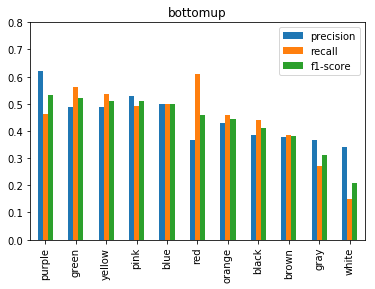

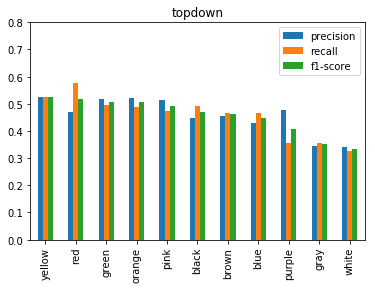

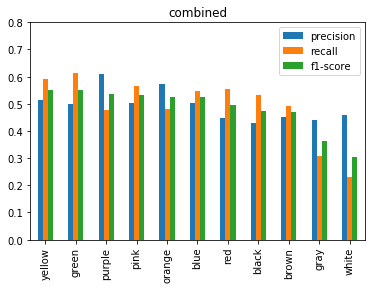

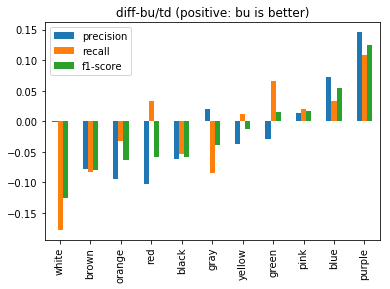

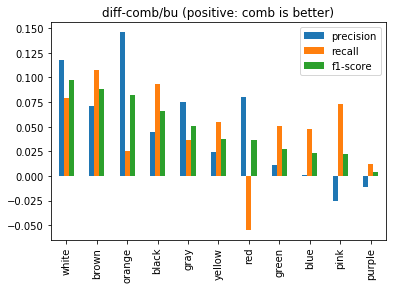

precision    recall  f1-score
white    0.117901  0.078979  0.097071
brown    0.070992  0.106926  0.088082
orange   0.145795  0.025516  0.082086
black    0.044937  0.093560  0.065500
gray     0.074792  0.036452  0.050879
yellow   0.024234  0.054678  0.037791
red      0.079926 -0.054678  0.036743
green    0.010681  0.051033  0.027526
blue     0.000504  0.047388  0.022898
pink    -0.025726  0.072904  0.022315
purple  -0.011558  0.012151  0.003490

In [16]:
bottomup_report['precision recall f1-score'.split()]\
    .sort_values(by=metric, ascending=False).plot(kind='bar', title='bottomup',ylim=(0,0.8))
plt.show()
topdown_report['precision recall f1-score'.split()]\
    .sort_values(by=metric, ascending=False).plot(kind='bar', title='topdown',ylim=(0,0.8))
plt.show()
combined_report['precision recall f1-score'.split()]\
    .sort_values(by=metric, ascending=False).plot(kind='bar', title='combined',ylim=(0,0.8))
plt.show()

diff_bu_td = (bottomup_report.sort_index() - topdown_report.sort_index())\
['precision recall f1-score'.split()]\
    .sort_values(by=metric)
diff_bu_td.plot(kind='bar', title='diff-bu/td (positive: bu is better)')
plt.show()


diff_comb_bu = (combined_report.sort_index() - bottomup_report.sort_index())\
['precision recall f1-score'.split()]\
.sort_values(by=metric, ascending=False)

diff_comb_bu.plot(kind='bar',title='diff-comb/bu (positive: comb is better)')
plt.show()

diff_comb_bu

## Mean Reciprocal Rank

In [28]:
mrr_df = pd.DataFrame(columns='BottomUp TopDown TopDownMultiTask Combined'.split()).T

mrr_df['all_obj'] = [evaluation.get_label_ranking_average_precision_score(pd.get_dummies(predict_df.color), eval(classifier+'_predict_df')) for classifier in classifier_list]
mrr_df['cdo'] = [evaluation.get_label_ranking_average_precision_score(pd.get_dummies(predict_cdo.color), eval(classifier+'_predict_df').loc[predict_cdo.index]) for classifier in classifier_list]
mrr_df['cbo'] = [evaluation.get_label_ranking_average_precision_score(pd.get_dummies(predict_cbo.color), eval(classifier+'_predict_df').loc[predict_cbo.index]) for classifier in classifier_list]
mrr_df['cno'] = [evaluation.get_label_ranking_average_precision_score(pd.get_dummies(predict_cno.color), eval(classifier+'_predict_df').loc[predict_cno.index]) for classifier in classifier_list]

print (mrr_df.round(3).to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  all\_obj &    cdo &    cbo &    cno \\
\midrule
BottomUp         &    0.616 &  0.682 &  0.573 &  0.652 \\
TopDown          &    0.631 &  0.699 &  0.593 &  0.607 \\
TopDownMultiTask &    0.547 &  0.706 &  0.501 &  0.493 \\
Combined         &    0.656 &  0.743 &  0.612 &  0.660 \\
\bottomrule
\end{tabular}



# Konfusionsmatrizen

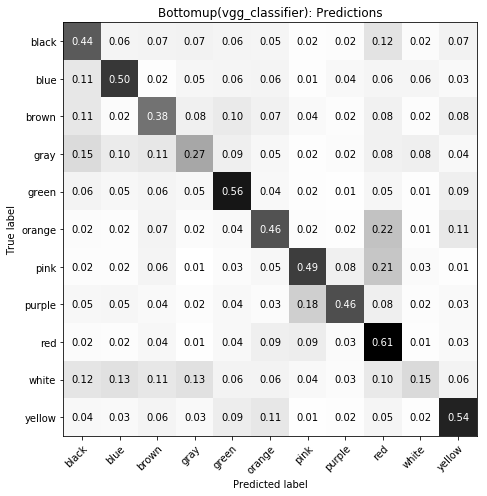

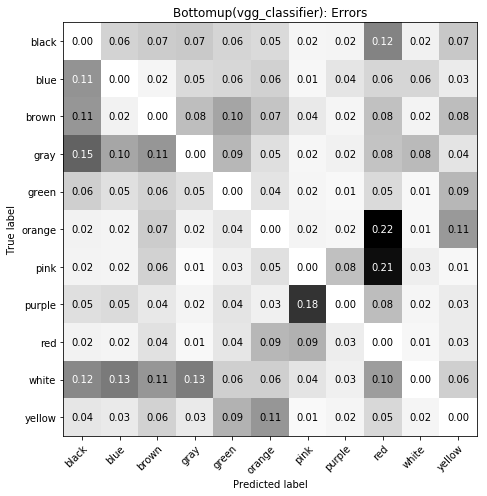

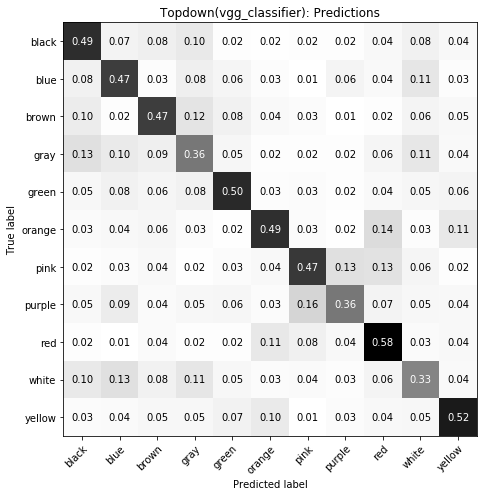

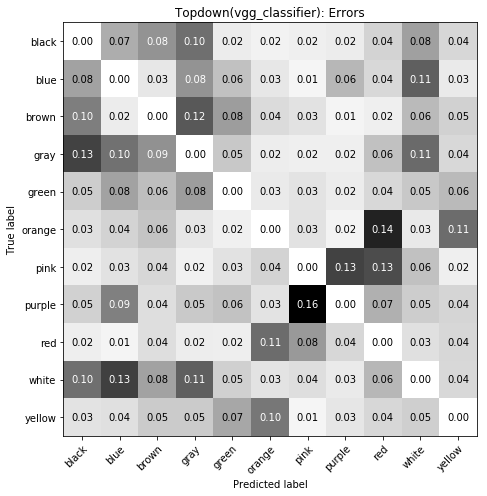

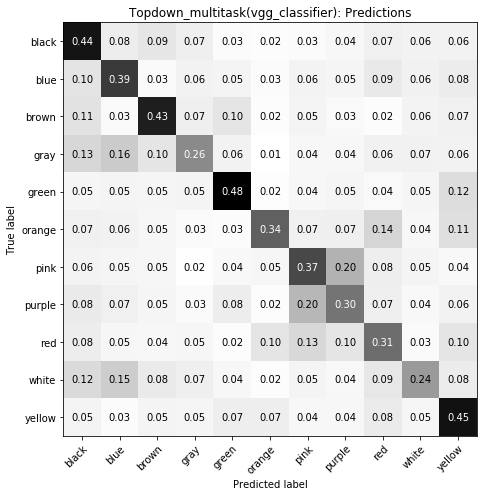

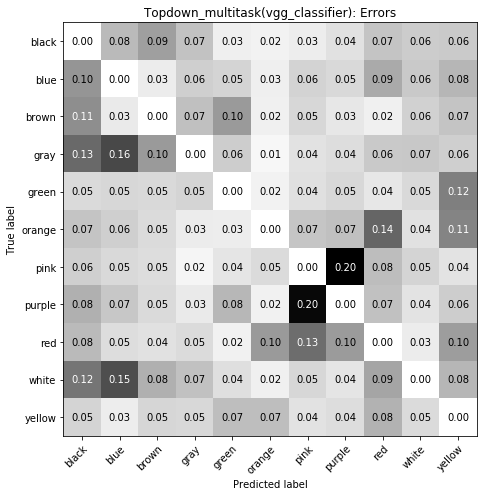

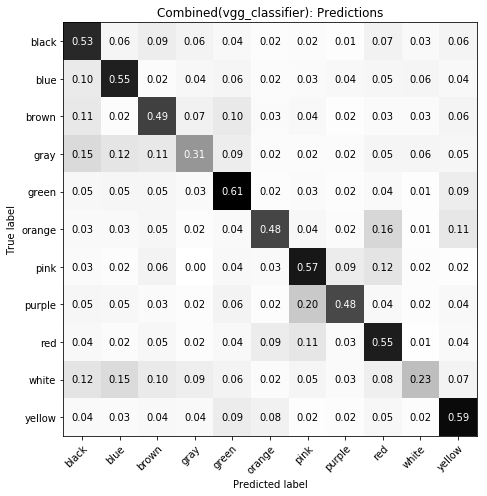

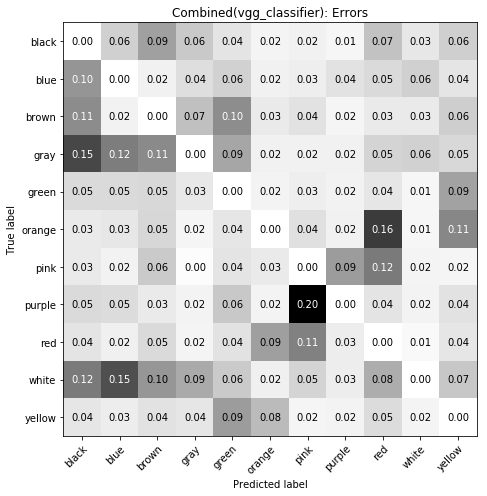

In [18]:
df = predict_df
save = True

for classifier in classifier_list:
    evaluation.plot_confusion_matrix(df['color'], df[classifier+'_color'], classes=colors, normalize=True, title=classifier.capitalize() + '(vgg_classifier): Predictions', error_matrix=False, cmap=plt.cm.Greys, colorbar=False, save_image=save, file_dir = vg_json_export+'images/')
    evaluation.plot_confusion_matrix(df['color'], df[classifier+'_color'], classes=colors, normalize=True, title=classifier.capitalize() + '(vgg_classifier): Errors', error_matrix=True, cmap=plt.cm.Greys, colorbar=False, save_image=save, file_dir = vg_json_export+'images/')

In [20]:
df = predict_df
recalibrated = df.loc[df['bottomup_color'] != df['combined_color']]#.loc[df['bottomup_color'] == df['color']]
print ('Items: {}, Rekalibrierte BU-Items: {} / {}%'.format(len(df), len(recalibrated), round((len(recalibrated)/len(df))*100,2)))

print ('BU und TD identisch: {}%'.format(round(len(df.loc[df['bottomup_color'] == df['topdown_color']]) / len(df)*100, 2)))
print ('TD und Komb identisch: {}%'.format(round(len(df.loc[df['combined_color'] == df['topdown_color']]) / len(df)*100, 2)))

print ('Accuracy von BottomUp-Klassifikator im rekalibrierten Subset:',round(accuracy_score(recalibrated['color'], recalibrated['bottomup_color']),3))
print ('Accuracy von TopDown-Klassifikator im rekalibrierten Subset:',round(accuracy_score(recalibrated['color'], recalibrated['topdown_color']),3))
print ('Accuracy von kombiniertem Klassifikator im rekalibrierten Subset:',round(accuracy_score(recalibrated['color'], recalibrated['combined_color']),3))

Items: 9053, Rekalibrierte BU-Items: 2633 / 29.08%
BU und TD identisch: 44.62%
TD und Komb identisch: 54.46%
Accuracy von BottomUp-Klassifikator im rekalibrierten Subset: 0.206
Accuracy von TopDown-Klassifikator im rekalibrierten Subset: 0.404
Accuracy von kombiniertem Klassifikator im rekalibrierten Subset: 0.37


In [21]:
influence_df = pd.DataFrame(columns = 'Items BU BU_ratio TD TD_ratio other other_ratio'.split())
for i,df in list(zip('all cdo cbo cno'.split(),[predict_df, predict_cdo, predict_cbo, predict_cno])):
    items = len(df)
    bu = len(df.loc[df['bottomup_color'] == df['combined_color']])
    td = len(df.loc[df['topdown_color'] == df['combined_color']])
    other = len(df.loc[df['bottomup_color'] != df['combined_color']].loc[df['topdown_color'] != df['combined_color']])
    influence_df = influence_df.append(pd.Series(
        {
            'Items':items,
            'BU':bu,
            'BU_ratio':round(bu/items,3),
            'TD':td,
            'TD_ratio':round(td/items,3),
            'other':other,
            'other_ratio':round(other/items,3)
        }
        ,name=i))
influence_df

Items      BU  BU_ratio      TD  TD_ratio   other  other_ratio
all  9053.0  6420.0     0.709  4930.0     0.545  1319.0        0.146
cdo  1141.0   775.0     0.679   767.0     0.672   161.0        0.141
cbo   883.0   625.0     0.708   438.0     0.496   135.0        0.153
cno  1755.0  1370.0     0.781   887.0     0.505   196.0        0.112

# Einfluss der Klassifikatoren

In [118]:
test = predict_df.copy()['color bottomup_color topdown_multitask_color combined_color'.split()]
test['BU=comb'] = test.apply(lambda x: x.combined_color == x.bottomup_color, axis=1)
test['TD=comb'] = test.apply(lambda x: x.combined_color == x.topdown_multitask_color, axis=1)

crosstab = pd.crosstab(test['BU=comb'], test['TD=comb'])# / len(test) 
crosstab = crosstab.T.round(3)

print (crosstab.to_latex())
crosstab

\begin{tabular}{lrr}
\toprule
BU=comb &  False &  True  \\
TD=comb &        &        \\
\midrule
False   &    289 &   3427 \\
True    &   2344 &   2993 \\
\bottomrule
\end{tabular}



BU=comb  False  True 
TD=comb              
False      289   3427
True      2344   2993

1141 Items, identische ausgeschlossen: False, relative Werte: False


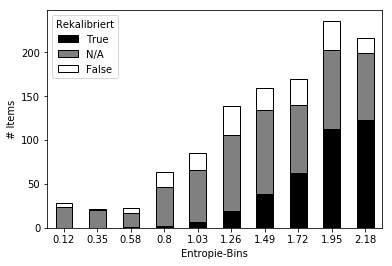

recalibrated     True   N/A  False
binned_entropy                    
0.116302          0.0  24.0    4.0
0.346500          0.0  20.0    1.0
0.575500          1.0  16.0    6.0
0.804500          2.0  44.0   18.0
1.034000          7.0  59.0   19.0
1.263500         19.0  87.0   33.0
1.492500         38.0  96.0   25.0
1.721500         63.0  77.0   30.0
1.950500        113.0  90.0   33.0
2.179500        123.0  76.0   17.0

In [124]:
classifier = 'bottomup'
df = predict_cdo
df_name='all' # für Bild-Export
exclude_identical = False
relative_values = False

# Definition von 'Rekalibriert': Bottom-Up-Vorhersage entspricht nicht der Vorhersage des kombinierten Klassifikators

entropy_df = df.copy()
entropy_df['entropy'] = eval(classifier+'_entropy_series').astype('float32')

# Einträge ausschließen in denen BU = TD

if exclude_identical:
    entropy_df = entropy_df.loc[entropy_df['bottomup_color'] != entropy_df['topdown_multitask_color']]

print (len(entropy_df), 'Items, identische ausgeschlossen: {}, relative Werte: {}'.format(exclude_identical, relative_values))

# Entropie-Bins
entropy_df['binned_entropy'] = pd.cut(entropy_df['entropy'], 10)
# Mittelwert der Bins als Name
entropy_df['binned_entropy'] = entropy_df.apply(lambda x: x.binned_entropy.mid, axis=1)

# Angabe, ob rekalibriert oder nicht
entropy_df['recalibrated'] = entropy_df.apply(
    lambda x:
        #'both' if (x.bottomup_color != x.combined_color and x.topdown_multitask_color != x.combined_color) else 
        'True' if x[classifier+'_color'] != x.combined_color 
        else 'False' if x.bottomup_color != x.topdown_multitask_color 
        else 'N/A' if x.bottomup_color == x.topdown_multitask_color 
        else 'ERROR', 
    axis=1
)

# DF umformen für Plot
entropy_df = entropy_df\
    .groupby(['binned_entropy', 'recalibrated']).size().unstack().fillna(value=0)


# Relative Anzahl der Trues und Falses berechnen
entropy_df['summe'] = entropy_df.sum(axis=1)
sums = entropy_df['summe'].to_list()

if relative_values:
    entropy_df['True'] = entropy_df.apply(lambda x: x['True']/x.summe,axis=1)
    entropy_df['False'] = entropy_df.apply(lambda x: x['False']/x.summe,axis=1)
    entropy_df['N/A'] = entropy_df.apply(lambda x: x['N/A']/x.summe,axis=1)

entropy_df = entropy_df.drop('summe', axis=1)
# Reihenfolge der Columns anpassen (True vor False -> Accuracy absteigend mit steigender Entropie)
entropy_df = entropy_df[entropy_df.columns.tolist()[::-1]]

# Plotten
ax = entropy_df.plot.bar(stacked=True, cmap=plt.get_cmap('gray'), edgecolor='black')
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [round(float(l),2) for l in labels]
ax.set_xticklabels(labels,rotation=0)
ax.set_xlabel('Entropie-Bins')
if relative_values:
    ax.set_ylabel('Verhältnis rekalibriert / nicht rekalibriert') 
else:
    ax.set_ylabel('# Items')
ax.legend(title='Rekalibriert',loc=0,fancybox = True)

# Einträge pro Bin über die jeweiligen Bars
#for x in set(zip(list(range(len(sums))),sums)):
#    ax.text(x[0],1.1,x[1],rotation=45,rotation_mode='anchor')

# Plot exportieren als png
#plt.savefig(vg_json_export+'images/'+'recalibrated_items_'+classifier+'_'+df_name+'.png',bbox_inches="tight")

plt.show()

entropy_df

In [24]:
def non_canonical_color(obj,color,cdo_map):
    if color != cdo_map[obj]:
        return True
    return False

non_canonical = predict_cdo.loc[predict_cdo.apply(lambda x: non_canonical_color(x.object_name, x.combined_color, color_diagnostic_objects), axis=1)]
print ('combined_classifier (late):',len (non_canonical)/len(predict_cdo))
print ('Accuracy:', round(accuracy_score(non_canonical['color'], non_canonical['combined_color']),3))

canonical = predict_cdo.loc[np.logical_not(predict_cdo.apply(lambda x: non_canonical_color(x.object_name, x.combined_color, color_diagnostic_objects), axis=1))]


combined_classifier (late): 0.3418054338299737
Accuracy: 0.179


In [56]:
canonical = predict_cdo.copy()
canonical['canonical_color'] = canonical.apply(lambda x: color_diagnostic_objects[x.object_name], axis=1)

print ('Farbe entspricht kanonischer Farbe:', len(canonical.loc[canonical.canonical_color == canonical.color]) / len(canonical))
print ('BU-Klassifikator sagt kanonische Farbe voraus:', len(canonical.loc[canonical.canonical_color == canonical.bottomup_color]) / len(canonical))
print ('TD-Klassifikator sagt kanonische Farbe voraus:', len(canonical.loc[canonical.canonical_color == canonical.topdown_color]) / len(canonical))
print ('TD_multitask-Klassifikator sagt kanonische Farbe voraus:', len(canonical.loc[canonical.canonical_color == canonical.topdown_multitask_color]) / len(canonical))
print ('Comb-Klassifikator sagt kanonische Farbe voraus:', len(canonical.loc[canonical.canonical_color == canonical.combined_color]) / len(canonical))

Farbe entspricht kanonischer Farbe: 0.7589833479404031
BU-Klassifikator sagt kanonische Farbe voraus: 0.5074496056091148
TD-Klassifikator sagt kanonische Farbe voraus: 0.5565293602103418
TD_multitask-Klassifikator sagt kanonische Farbe voraus: 0.6643295354951797
Comb-Klassifikator sagt kanonische Farbe voraus: 0.6581945661700263


# Accuracy Objektidentifikation

In [110]:
object_labels = np.load(input_dir+'../feature_arrays/type_to_color_resampled.npz')[set_type+'_x']
object_predictions = topdown_multitask_arrays['predict_'+set_type+'_objects']
ids = topdown_multitask_arrays[set_type+'_y'][:,0:1]
object_predictions = np.append(ids, object_predictions, axis=1)

print ('IDs nicht identisch') if False in object_labels[:,0]==object_predictions[:,0] else print ('')

object_labels_ix = np.argmax(object_labels[:,1:], axis=1)
object_predictions_ix = np.argmax(object_predictions[:,1:], axis=1)

print ('Accuracy Objektklassen: ', round(accuracy_score(object_labels_ix, object_predictions_ix), 3))


Accuracy Objektklassen:  0.367
